In [28]:
import torch
import random
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import Omniglot
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

In [3]:
class OmniglotFewShot(Dataset):
    def __init__(self, root, mode="train", transform=None, n_way=5, k_shots=5, n_query=5):
        super(OmniglotFewShot, self).__init__()
        self.root = root
        self.transform = transform
        self.n_way = n_way
        self.k_shots = k_shots
        self.n_query = n_query
        self.mode = mode
        self.data = Omniglot(root=self.root, background=True if self.mode == "train" else False, download=True, transform=self.transform)
        self.indices_by_class = self._create_indices_by_class()

    def _create_indices_by_class(self):
        indices_by_class = {}
        for idx, (_, label) in enumerate(self.data):
            if label not in indices_by_class:
                indices_by_class[label] = []
            indices_by_class[label].append(idx)
        return indices_by_class

    def __len__(self):
        return len(self.indices_by_class)

    def __getitem__(self, _):
        class_indices = np.random.choice(list(self.indices_by_class.keys()), self.n_way, replace=False)
        
        support_set = []
        query_set = []
        support_labels = []
        query_labels = []

        for class_index in class_indices:
            indices = np.random.choice(self.indices_by_class[class_index], self.k_shots + self.n_query, replace=False)
            class_support_set_indices = indices[:self.k_shots]
            class_query_set_indices = indices[self.k_shots:]

            for i in class_support_set_indices:
                image, _ = self.data[i]
                support_set.append(image)
                support_labels.append(class_index)

            for i in class_query_set_indices:
                image, _ = self.data[i]
                query_set.append(image)
                query_labels.append(class_index)

        # Convert lists to tensors for PyTorch compatibility
        support_set = torch.stack(support_set)
        query_set = torch.stack(query_set)
        support_labels = torch.tensor(support_labels)
        query_labels = torch.tensor(query_labels)

        return support_set, query_set, support_labels, query_labels


In [4]:
class RandomRotation90:
    def __call__(self, img):
        angle = random.choice([0, 90, 180, 270])
        return transforms.functional.rotate(img, angle)

In [5]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    RandomRotation90(),
    transforms.ToTensor()
])


In [6]:
train_dataset = OmniglotFewShot(root='./data', mode='train', transform=transform, n_way=60, k_shots=5, n_query=5)
test_dataset = OmniglotFewShot(root='./data', mode='test', transform=transform, n_way=5, k_shots=5, n_query=15)

Files already downloaded and verified
Files already downloaded and verified


In [7]:

train_loader = DataLoader(train_dataset,shuffle=True)
test_loader = DataLoader(test_dataset,shuffle=False)

In [8]:
a = next(iter(train_loader))

In [14]:
a[3]

tensor([[655, 655, 655, 655, 655, 924, 924, 924, 924, 924, 662, 662, 662, 662,
         662, 834, 834, 834, 834, 834, 937, 937, 937, 937, 937, 205, 205, 205,
         205, 205,  90,  90,  90,  90,  90, 672, 672, 672, 672, 672, 833, 833,
         833, 833, 833,  71,  71,  71,  71,  71, 174, 174, 174, 174, 174, 685,
         685, 685, 685, 685,  80,  80,  80,  80,  80, 535, 535, 535, 535, 535,
         849, 849, 849, 849, 849, 429, 429, 429, 429, 429, 765, 765, 765, 765,
         765, 492, 492, 492, 492, 492, 189, 189, 189, 189, 189, 959, 959, 959,
         959, 959, 619, 619, 619, 619, 619, 351, 351, 351, 351, 351, 273, 273,
         273, 273, 273, 154, 154, 154, 154, 154, 817, 817, 817, 817, 817, 352,
         352, 352, 352, 352, 620, 620, 620, 620, 620, 644, 644, 644, 644, 644,
         519, 519, 519, 519, 519, 819, 819, 819, 819, 819, 544, 544, 544, 544,
         544, 216, 216, 216, 216, 216, 551, 551, 551, 551, 551, 841, 841, 841,
         841, 841, 729, 729, 729, 729, 729,  42,  42

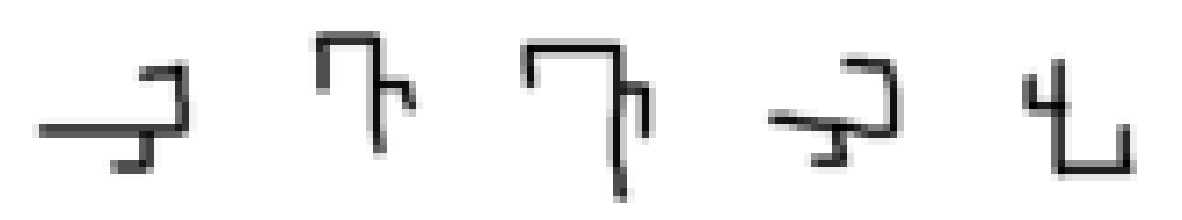

In [15]:
import matplotlib.pyplot as plt

def visualize_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i][0], cmap='gray')  
        ax.axis('off')
    plt.show()

visualize_images(a[0].squeeze(0), num_images=5)  

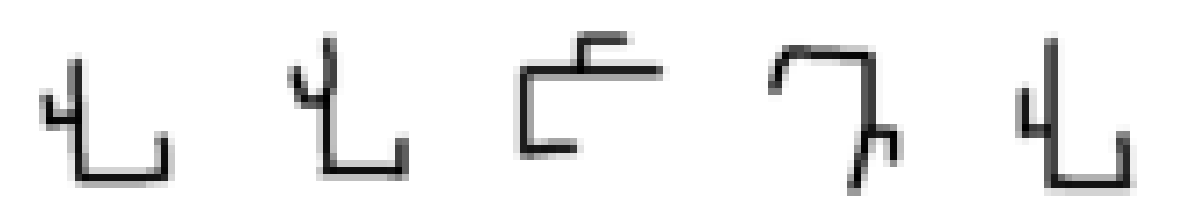

In [16]:
visualize_images(a[1].squeeze(0), num_images=5)

In [17]:
class Embedder(nn.Module):
    def __init__(self):
        super(Embedder, self).__init__()
        self.in_channels = 1
        self.out_channels = 64

        self.encoder = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        return x


In [18]:
Embedder = Embedder()

In [36]:
x = Embedder(a[0].squeeze(0))

In [20]:
x.shape

torch.Size([300, 64])

In [37]:
a[0].shape

torch.Size([1, 300, 1, 28, 28])

In [38]:
a[1].shape

torch.Size([1, 300, 1, 28, 28])

In [23]:
a[2]==a[3]

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, T

In [26]:
a[2].shape

torch.Size([1, 300])

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [39]:
class Protonet(nn.Module):
    def __init__(self, embedder):
        super(Protonet, self).__init__()
        self.embedder = embedder

    def forward(self, support, query, n_way, k_shots):
        """
        Perform the forward pass and compute the prototypes.

        Parameters:
        - support: The support set.
        - query: The query set.
        - n_way: The number of classes (ways).
        - k_shots: The number of examples per class in the support set.

        Returns:
        - query_embeddings: The embeddings of the query set.
        - prototypes: The class prototypes.
        """
        # Embed support and query sets
        print(support.shape)
        support_embeddings = self.embedder(support.squeeze(0))
        query_embeddings = self.embedder(query.squeeze(0))
        
        # Calculate the prototypes for each class in the support set
        # Reshape support embeddings to [n_way, k_shots, embedding_size] and compute mean across k_shots
        prototypes = support_embeddings.view(n_way, k_shots, -1).mean(dim=1)
        
        return query_embeddings, prototypes


In [40]:
model = Protonet(Embedder)

In [ ]:

def protonet_loss(query_embeddings, prototypes, query_labels, n_way):
    """
    Computes the Prototypical Networks loss given embeddings of the query set,
    class prototypes, and query labels.

    Parameters:
    - query_embeddings: The embeddings of the query set.
    - prototypes: The class prototypes.
    - query_labels: The labels for the query set.
    - n_way: The number of classes (ways).

    Returns:
    - Loss calculated using Negative Log Likelihood.
    """
    # Calculate the Euclidean distance from each query sample to the prototypes
    distances = torch.cdist(query_embeddings, prototypes)
    
    # Convert distances to log probabilities
    log_p_y = nn.functional.log_softmax(-distances, dim=1)
    
    # Calculate and return the loss
    loss = nn.functional.nll_loss(log_p_y, query_labels.long())
    return loss
